In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random

In [97]:
import warnings
warnings.filterwarnings("ignore")

In [98]:
# Set seeds for TensorFlow and NumPy
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

## Load combined_df

In [99]:
combined_df = pd.read_csv('combined_df.csv')

In [100]:
combined_df.columns

Index(['Well', 'Depth', 'Clay', 'Quartz', 'Carbonates', 'TOC', 'Formation',
       'Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity', 'Density',
       'Photoelectric', 'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens', 'PEF_Dens',
       'Jun_classif', 'Jun_unified', 'Jun_classif_classes',
       'Jun_unified_classes', 'TOC_class', 'well_number', 'Well Number'],
      dtype='object')

In [101]:
# Rename Depth column to depth

combined_df.rename(columns={'Depth': 'depth'}, inplace=True)

In [102]:
combined_df.drop(columns=['Clay', 'Carbonates', 'Jun_classif', 'Jun_unified', 'Jun_classif_classes',
       'Jun_unified_classes', 'TOC_class', 'well_number'], inplace=True)

<Axes: >

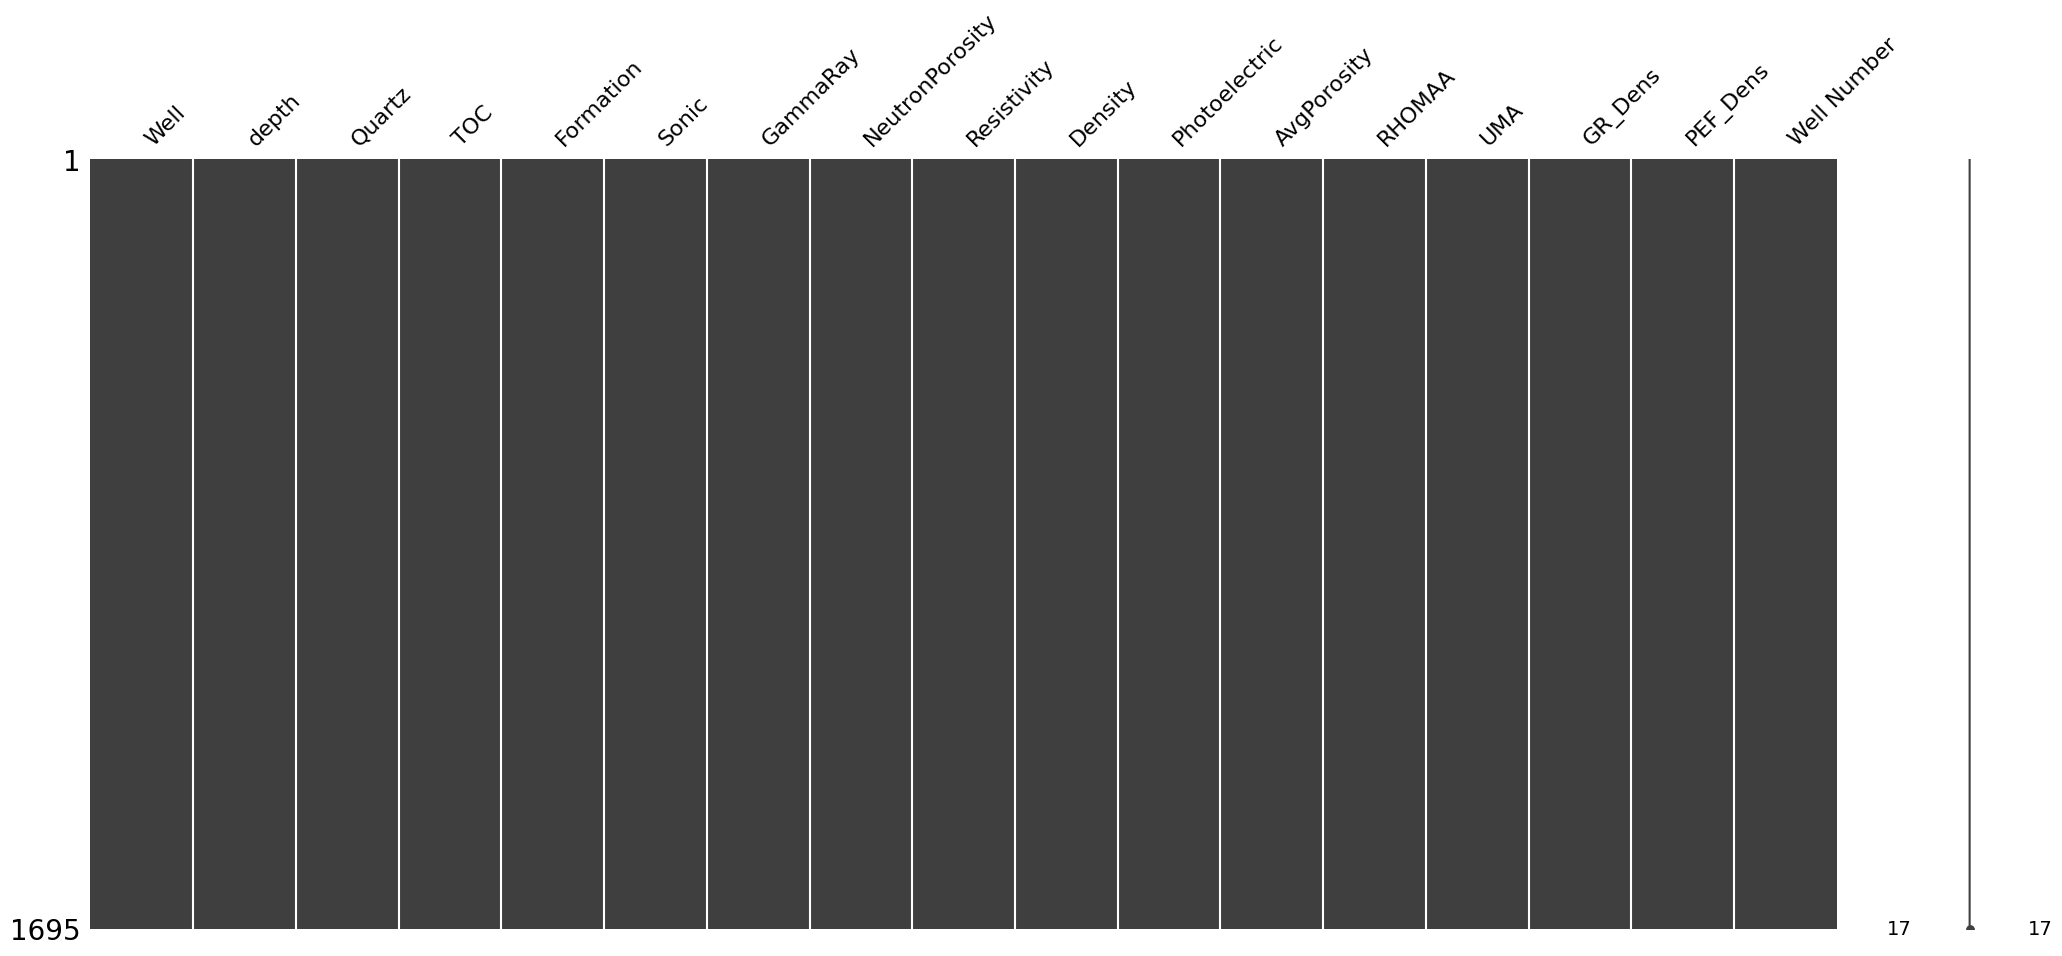

In [103]:
import missingno as msno 

msno.matrix(combined_df)

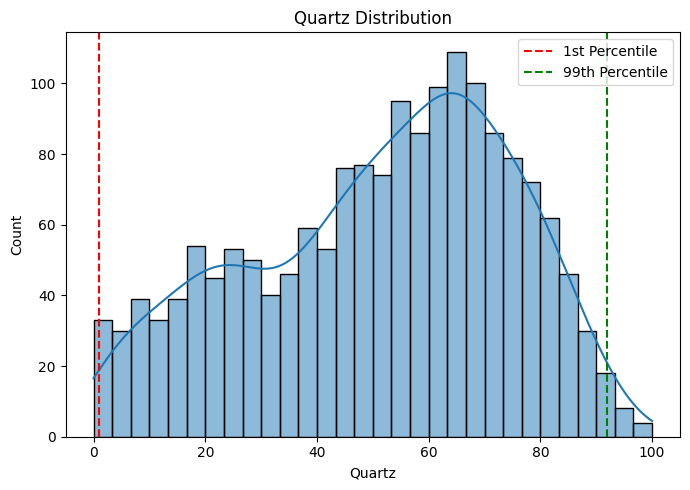

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

feature = 'Quartz'
sns.histplot(combined_df[feature], bins=30, kde=True)
plt.title(f"{feature} Distribution")
plt.axvline(combined_df[feature].quantile(0.01), color='red', linestyle='--', label='1st Percentile')
plt.axvline(combined_df[feature].quantile(0.99), color='green', linestyle='--', label='99th Percentile')
plt.legend()

plt.tight_layout()
plt.show()

In [105]:
# Evita divisiones por cero
combined_df['NeutronPorosity'].replace(0, 1e-6, inplace=True)
combined_df['Density'].replace(0, 1e-6, inplace=True)
combined_df['Sonic'].replace(0, 1e-6, inplace=True)

# 2. Sonic - NeutronPorosity
combined_df['Sonic_NP_Diff'] = combined_df['Sonic'] - combined_df['NeutronPorosity']
combined_df['Sonic_NP_AbsDiff'] = np.abs(combined_df['Sonic_NP_Diff'])

# 3. Sonic × Density
combined_df['Sonic_Density_Product'] = combined_df['Sonic'] * combined_df['Density']

# 4. Inverso del producto (puede resaltar diferencias)
combined_df['Inv_Sonic_Density'] = 1 / combined_df['Sonic_Density_Product']

# 5. Photoelectric - valor de referencia para cuarzo (~1.81)
combined_df['PE_Departure_Quartz'] = combined_df['Photoelectric'] - 1.81

# 6. Clean Sand Index (combinación GR bajo y Densidad alta)
combined_df['CleanSandIndex'] = (1 - combined_df['GammaRay'] / combined_df['GammaRay'].max()) * (combined_df['Density'] / combined_df['Density'].max())

# 7. Resistivity / NeutronPorosity (tipo relación de Archie)
combined_df['ArchieRatio'] = combined_df['Resistivity'] / combined_df['NeutronPorosity']

# 8. Rolling statistics (ventana de 5 muestras)
window_size = 5
for col in ['Sonic', 'Density', 'GammaRay']:
    combined_df[f'{col}_roll_mean'] = combined_df[col].rolling(window=window_size, center=True, min_periods=1).mean()
    combined_df[f'{col}_roll_std'] = combined_df[col].rolling(window=window_size, center=True, min_periods=1).std().fillna(0)

print("✅ Características calculadas añadidas exitosamente a combined_df.")

✅ Características calculadas añadidas exitosamente a combined_df.


In [106]:
features = [
    # Originales
    'Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity', 'Density', 'Photoelectric',
    'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens', 'PEF_Dens']

features_calculated = [
    # Calculadas
    'Sonic_NP_Diff',
    'Sonic_NP_AbsDiff',
    'Sonic_Density_Product',
    'Inv_Sonic_Density',
    'PE_Departure_Quartz',
    'CleanSandIndex',
    'ArchieRatio',
    'Sonic_roll_mean',
    'Sonic_roll_std',
    'Density_roll_mean',
    'Density_roll_std',
    'GammaRay_roll_mean',
    'GammaRay_roll_std']


In [107]:
target = 'Quartz'

In [108]:
# Split into X and y
X = combined_df[features + features_calculated].copy()
y = combined_df[target]

In [109]:
# Handle outliers (optional)

q_low, q_high = y.quantile(0.01), y.quantile(0.99)
y = y[(y >= q_low) & (y <= q_high)]
X = X.loc[y.index]

In [110]:
# Train-test split
y_bins = pd.qcut(y, q=10, labels=False)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y_bins, test_size=0.3, random_state=42)

# Calculate sample weights based on bin frequency
def calculate_sample_weights(y, bins=15):
    hist, bin_edges = np.histogram(y, bins=bins)
    max_freq = np.max(hist)
    weights = np.zeros(len(y))
    for i in range(bins):
        bin_mask = (y >= bin_edges[i]) & (y < bin_edges[i + 1])
        freq = hist[i]
        if freq > 0:
            weights[bin_mask] = np.log1p(max_freq / freq)
    return weights

sample_weights = calculate_sample_weights(y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [111]:
# Train XGBoost on extracted CNN features
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,  # L1 regularization
    reg_lambda=2.0,  # L2 regularization
    random_state=42,
    early_stopping_rounds=30
)

xgb_model.fit(X_train_scaled, y_train, sample_weight=sample_weights, eval_set=[(X_val_scaled, y_val)], verbose=10)

# Predict on validation set
y_val_pred = xgb_model.predict(X_val_scaled)

[0]	validation_0-rmse:21.88310
[10]	validation_0-rmse:17.67179
[20]	validation_0-rmse:16.94088


[30]	validation_0-rmse:16.71092
[40]	validation_0-rmse:16.61101
[50]	validation_0-rmse:16.52606
[60]	validation_0-rmse:16.62859
[70]	validation_0-rmse:16.61720
[76]	validation_0-rmse:16.60134


In [112]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate predictions on validation set
rmse = mean_squared_error(y_val, y_val_pred) ** 0.5  # Manually calculate RMSE for older scikit-learn versions
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")
print(f"Validation R²: {r2:.4f}")

Validation RMSE: 16.4975
Validation MAE: 12.3139
Validation R²: 0.4643


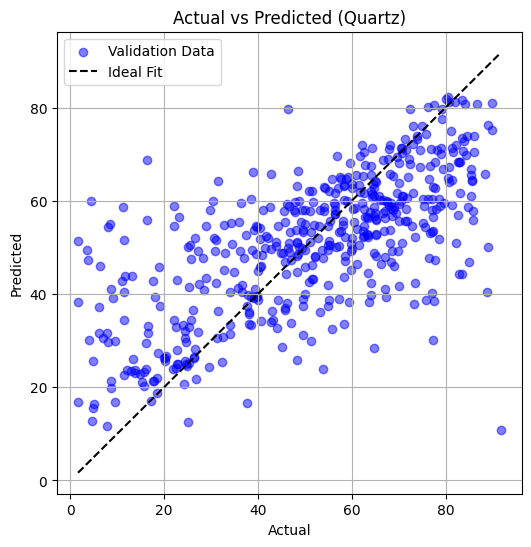

In [113]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5, label="Validation Data", color="blue")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', label="Ideal Fit")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted ({target})")
plt.legend()
plt.grid()
plt.show()

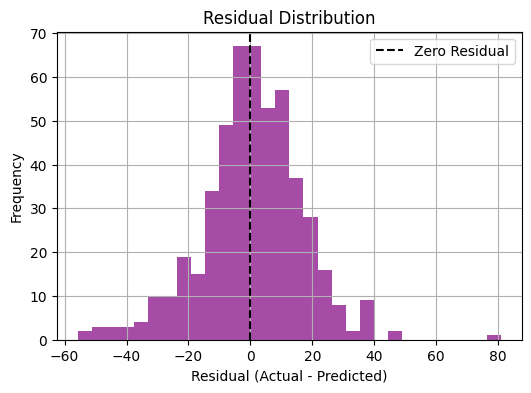

In [114]:
# Residual plot
residuals = y_val - y_val_pred

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, alpha=0.7, color='purple')
plt.axvline(x=0, color='black', linestyle='--', label='Zero Residual')
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

### Hyperparameter Tuning XGB

In [133]:
import numpy as np
from sklearn.model_selection import GridSearchCV, ParameterGrid, KFold
from xgboost import XGBRegressor
from pactools.utils.progress_bar import ProgressBar  # pip install pactools
import warnings

warnings.filterwarnings("ignore")

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0.5, 1.0],
    'reg_lambda': [2.0, 5.0],
    'early_stopping_rounds': [10, 30, 50]
}

# Generate all combinations
param_combinations = list(ParameterGrid(param_grid))

# Initialize progress bar
progress_bar = ProgressBar(title="Hyperparameter Tuning", max_value=len(param_combinations), spinner=True)

# Custom GridSearchCV with progress bar
class ProgressBarGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        self._progress_bar = progress_bar
        self._progress_bar.update(0)
        result = super().fit(X, y, **fit_params)
        self._progress_bar.close()
        return result

    def _run_search(self, evaluate_candidates):
        def wrapped_evaluate_candidates(candidate_params):
            for candidate in candidate_params:
                results = evaluate_candidates([candidate])
                self._progress_bar.update_with_increment_value(1, title=f"Completed: {candidate}")
            return results
        super()._run_search(wrapped_evaluate_candidates)

# Set up cross-validation
cv = KFold(n_splits=5)

# Initialize grid search
grid_search = ProgressBarGridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    verbose=0,
    n_jobs=-1
)

# Fit the model (with sample weights)
grid_search.fit(X_train_scaled, y_train, sample_weight=sample_weights, eval_set=[(X_val_scaled, y_val)], verbose=0)

# Results
print(f"✅ Best Parameters: {grid_search.best_params_}")
print(f"✅ Best R² Score: {grid_search.best_score_:.4f}")

[........................................] 100% / 263.30 sec | Completed: {'colsample_bytree': 0.8, 'early_stopping_rounds': 50, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 1.0, 'reg_lambda': 5.0, 'subsample': 0.8} 
✅ Best Parameters: {'colsample_bytree': 0.7, 'early_stopping_rounds': 30, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.7}
✅ Best R² Score: 0.4058


In [137]:
best_xgb_params = grid_search.best_params_

In [138]:
best_xgb_params

{'colsample_bytree': 0.7,
 'early_stopping_rounds': 30,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 100,
 'reg_alpha': 1.0,
 'reg_lambda': 2.0,
 'subsample': 0.7}

In [139]:
best_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    **best_xgb_params,
    random_state=42
)

In [140]:
best_xgb_model.fit(X_train_scaled, y_train, sample_weight=sample_weights, eval_set=[(X_val_scaled, y_val)], verbose=False)

# Predict on validation set
y_val_pred = best_xgb_model.predict(X_val_scaled)

# Predict on training set for comparison
y_train_pred = best_xgb_model.predict(X_train_scaled)

# Evaluate performance on test set
rmse = mean_squared_error(y_val, y_val_pred) ** 0.5  # Manually calculate RMSE
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

# Evaluate performance on training set
train_rmse = mean_squared_error(y_train, y_train_pred) ** 0.5  # Manually calculate RMSE
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Final Validation RMSE: {rmse:.4f}")
print(f"Final Validation MAE: {mae:.4f}")
print(f"Final Validation R²: {r2:.4f}")

print(f"Final Training RMSE: {train_rmse:.4f}")
print(f"Final Training MAE: {train_mae:.4f}")
print(f"Final Training R²: {train_r2:.4f}")

Final Validation RMSE: 16.6645
Final Validation MAE: 12.7339
Final Validation R²: 0.4534
Final Training RMSE: 13.6879
Final Training MAE: 10.6677
Final Training R²: 0.6381


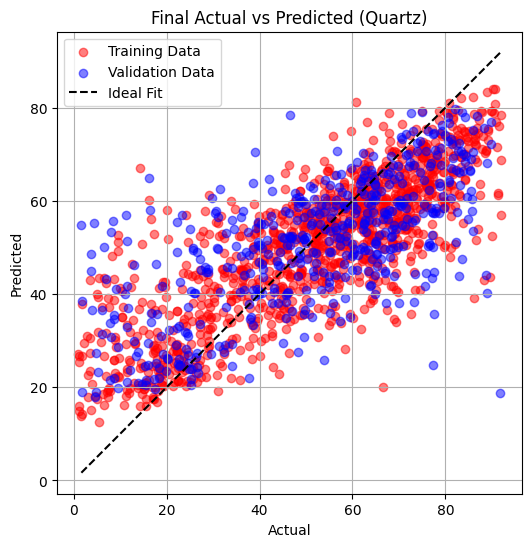

In [141]:
# Scatter plot of actual vs. predicted
plt.figure(figsize=(6, 6))

plt.scatter(y_train, y_train_pred, alpha=0.5, label="Training Data", color="red")
plt.scatter(y_val, y_val_pred, alpha=0.5, label="Validation Data", color="blue")

plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', label="Ideal Fit")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Final Actual vs Predicted ({target})")
plt.legend()
plt.grid()
plt.show()

### Cross Validation

In [142]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
fold_rmse, fold_mae, fold_r2 = [], [], []
train_rmse, train_mae, train_r2 = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
    print(f"\nFold {fold + 1}")
    
    # Split data
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]  # Use `.iloc` for positional indexing

    # Initialize and train XGBoost model
    fold_xgb_model = XGBRegressor(**best_xgb_params, objective='reg:squarederror', random_state=42)
    fold_xgb_model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],  # Add validation dataset for early stopping
        verbose=False  # Suppress verbose output
    )

    # Predict on validation and training sets
    y_val_pred = fold_xgb_model.predict(X_val_fold)
    y_train_pred = fold_xgb_model.predict(X_train_fold)

    # Ensure compatibility: If y_train and y_val are transformed (e.g., log-transformed), reverse it
    if hasattr(y_train, 'apply') and np.log1p(y_train).equals(y_train):  # Example transformation check
        y_val_pred = np.expm1(y_val_pred)
        y_train_pred = np.expm1(y_train_pred)
        y_val_fold = np.expm1(y_val_fold)
        y_train_fold = np.expm1(y_train_fold)

    # Calculate metrics for validation set
    val_rmse = mean_squared_error(y_val_fold, y_val_pred) ** 0.5  # Manually calculate RMSE
    val_mae = mean_absolute_error(y_val_fold, y_val_pred)
    val_r2 = r2_score(y_val_fold, y_val_pred)

    # Calculate metrics for training set
    tr_rmse = mean_squared_error(y_train_fold, y_train_pred) ** 0.5  # Manually calculate RMSE
    tr_mae = mean_absolute_error(y_train_fold, y_train_pred)
    tr_r2 = r2_score(y_train_fold, y_train_pred)

    # Append metrics to the lists
    fold_rmse.append(val_rmse)
    fold_mae.append(val_mae)
    fold_r2.append(val_r2)
    train_rmse.append(tr_rmse)
    train_mae.append(tr_mae)
    train_r2.append(tr_r2)

    print(f"Validation RMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")
    print(f"Training RMSE: {tr_rmse:.4f}, MAE: {tr_mae:.4f}, R²: {tr_r2:.4f}")

# Summarize results
print("\nCross-Validation Results:")
print(f"Validation RMSE: {np.mean(fold_rmse):.4f} ± {np.std(fold_rmse):.4f}")
print(f"Validation MAE: {np.mean(fold_mae):.4f} ± {np.std(fold_mae):.4f}")
print(f"Validation R²: {np.mean(fold_r2):.4f} ± {np.std(fold_r2):.4f}")

print(f"Training RMSE: {np.mean(train_rmse):.4f} ± {np.std(train_rmse):.4f}")
print(f"Training MAE: {np.mean(train_mae):.4f} ± {np.std(train_mae):.4f}")
print(f"Training R²: {np.mean(train_r2):.4f} ± {np.std(train_r2):.4f}")


Fold 1
Validation RMSE: 17.4795, MAE: 13.3056, R²: 0.3745
Training RMSE: 12.2314, MAE: 9.2726, R²: 0.7143

Fold 2
Validation RMSE: 18.2797, MAE: 13.6194, R²: 0.3313
Training RMSE: 12.5311, MAE: 9.5043, R²: 0.6994

Fold 3
Validation RMSE: 17.7841, MAE: 13.4205, R²: 0.4205
Training RMSE: 13.3435, MAE: 10.0205, R²: 0.6514

Fold 4
Validation RMSE: 17.5162, MAE: 13.0886, R²: 0.4010
Training RMSE: 13.3573, MAE: 10.2227, R²: 0.6563

Fold 5
Validation RMSE: 17.1502, MAE: 12.8796, R²: 0.4481
Training RMSE: 11.6603, MAE: 8.8200, R²: 0.7346

Cross-Validation Results:
Validation RMSE: 17.6419 ± 0.3771
Validation MAE: 13.2627 ± 0.2573
Validation R²: 0.3951 ± 0.0400
Training RMSE: 12.6247 ± 0.6553
Training MAE: 9.5680 ± 0.5068
Training R²: 0.6912 ± 0.0325



Fold 1


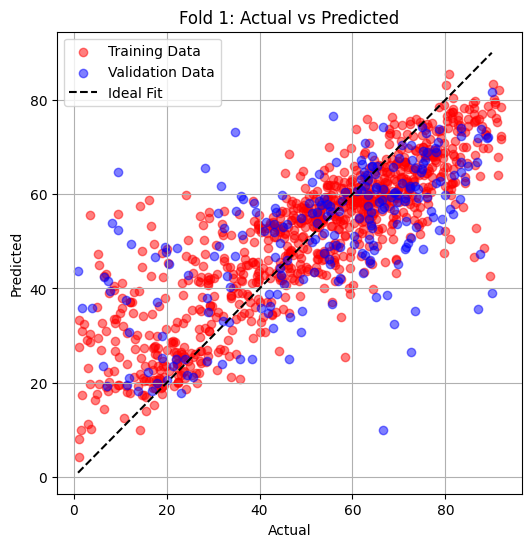


Fold 2


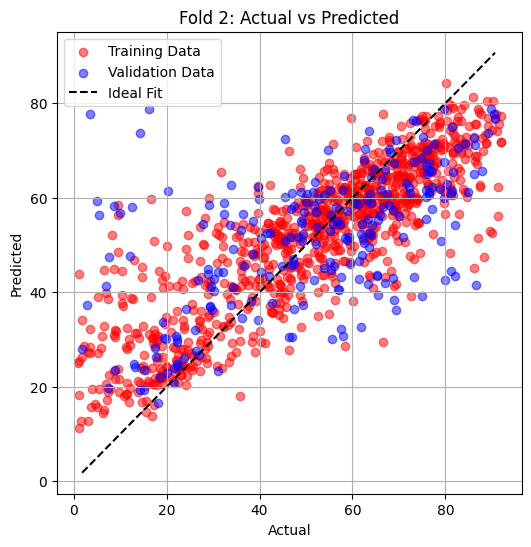


Fold 3


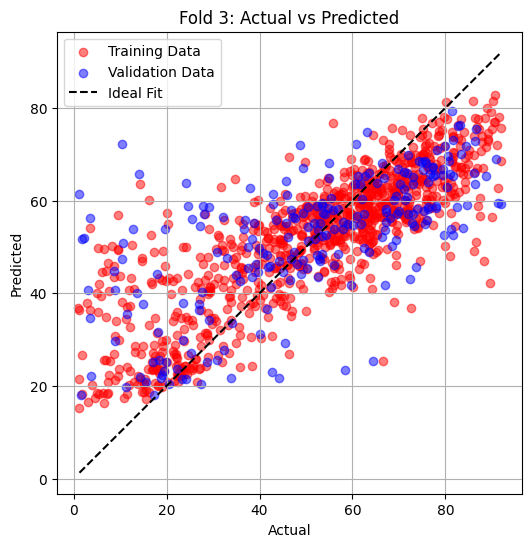


Fold 4


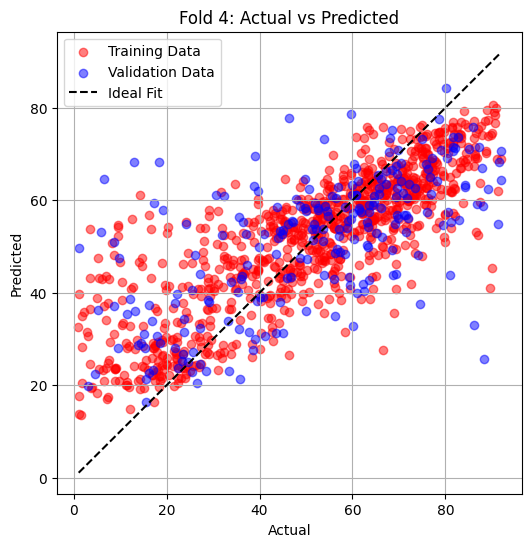


Fold 5


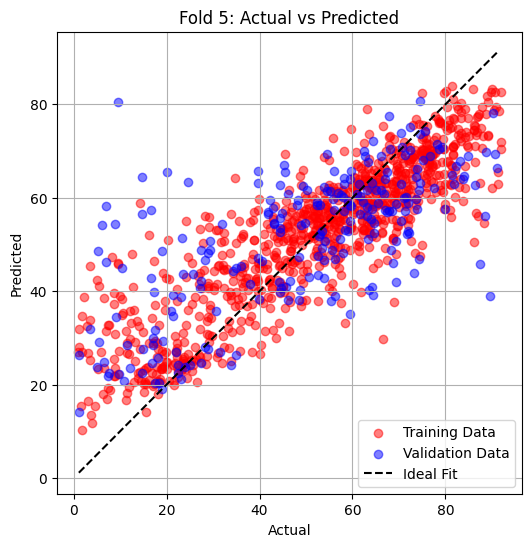

In [143]:
import matplotlib.pyplot as plt

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
    print(f"\nFold {fold + 1}")
    
    # Split and scale data
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Scale only on training data
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)

    # Initialize and train XGBoost model
    fold_xgb_model = XGBRegressor(**best_xgb_params, objective='reg:squarederror', random_state=42)
    fold_xgb_model.fit(
        X_train_fold, y_train_fold,
        eval_set=[(X_val_fold, y_val_fold)],  # Add validation dataset for early stopping
        verbose=False  # Suppress verbose output
    )

    # Predict on validation and training sets
    y_val_pred = fold_xgb_model.predict(X_val_fold)
    y_train_pred = fold_xgb_model.predict(X_train_fold)

    # Handle log-transformed targets
    if hasattr(y_train_fold, 'apply') and np.log1p(y_train_fold).equals(y_train_fold):
        y_train_fold = np.expm1(y_train_fold)
        y_val_fold = np.expm1(y_val_fold)
        y_train_pred = np.expm1(y_train_pred)
        y_val_pred = np.expm1(y_val_pred)

    # Scatter plot for this fold
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_fold, y_train_pred, alpha=0.5, label="Training Data", color="red")
    plt.scatter(y_val_fold, y_val_pred, alpha=0.5, label="Validation Data", color="blue")
    plt.plot([y_val_fold.min(), y_val_fold.max()],
             [y_val_fold.min(), y_val_fold.max()],
             'k--', label="Ideal Fit")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Fold {fold + 1}: Actual vs Predicted")
    plt.legend()
    plt.grid()
    plt.show()

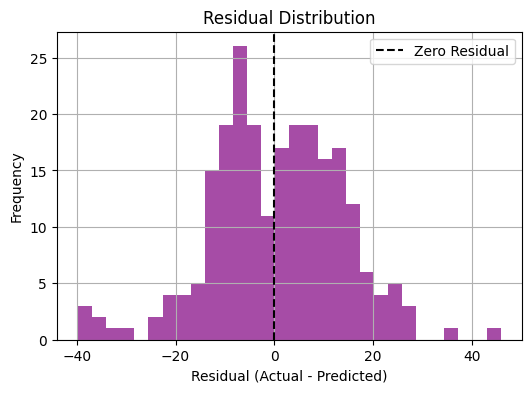

In [144]:
# Use the last fold's validation indices to ensure shapes match
_, val_idx = list(kf.split(X_train_scaled))[-1]
y_val_fold = y_train.iloc[val_idx]
y_val_pred_fold = best_xgb_model.predict(X_train_scaled[val_idx])

residuals = y_val_fold - y_val_pred_fold

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, alpha=0.7, color='purple')
plt.axvline(x=0, color='black', linestyle='--', label='Zero Residual')
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()